In [1]:
import autograd.numpy as np
import autograd as ad
from autograd import grad 
from autograd.misc.optimizers import adam
from autograd.misc.optimizers import sgd
import matplotlib.pyplot as plt
import statistics 
import pickle
from sklearn import linear_model
from scipy.optimize import minimize

Dictionary searching problem: A data is generated by the SDE
$$dX = -Xdt +  dW, \qquad.$$ 
Identify the SDE in dictionary. 


In [2]:
"""
with open('/Users/rkyoon/Dropbox/UH&RICE/BRN/code/Data/data_simple.pickle', 'rb') as f:
    [Xt,X_avg,t]= pickle.load(f)
"""

with open('/Users/rkyoon/Dropbox/UH&RICE/BRN/code/Data/data_simple_long.pickle', 'rb') as f:
    [Xt,t]= pickle.load(f)



In [3]:
N = len(Xt)
X0 = Xt[0]

N_data = 100
Xt_reduce = Xt[:N_data]
T_reduce = t[N_data]

dt = t[1]-t[0]
T = t[-1]
print(dt)

0.01000050002500125


In [4]:
T

200.0

In [5]:
N

20000

In [230]:
dW = np.random.normal(0,np.sqrt(dt),N)
print(np.sum(dW/dt)/N)
print(np.sum(dW/dt)**2/N)

0.04497805021811166
40.46050002845948


In [231]:
mu_tr = -1
sigma_tr = 1

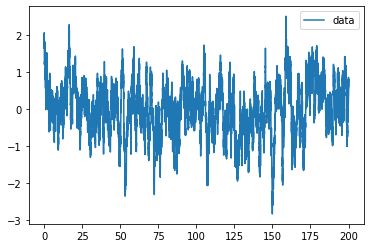

In [232]:
# plot the data
plt.plot(t,Xt)

plt.legend(['data','avg'],)
plt.show()

In [285]:
def dic(Xt):
    return np.column_stack((np.ones((len(Xt),)),Xt,Xt**2/2))

In [307]:
def loss_print(para,args = (Xt,dic, dt,lamb)):
    alpha, beta = para
    dX = (Xt[1:]-Xt[:-1])
   
    N = len(dX)-1
    dic_X = dic(Xt[:-1])
    
    
    drift_loss = np.sum((dX/dt - dic_X@alpha)**2)/N
    diff_loss = np.sum(((dX - dt*dic_X@alpha)**2/dt - (dic_X@beta)**2)**2)/N
    

    reg = lamb*np.sum(np.abs(para))
    
    return drift_loss, diff_loss, reg
    

In [308]:
def loss(para, args = (Xt,dic, dt,lamb)):
    
    alpha, beta = para
    dX = (Xt[1:]-Xt[:-1])
   
    N = len(dX)-1
    dic_X = dic(Xt[:-1])
    
    
    
    drift_loss = np.sum((dX/dt - dic_X@alpha)**2)/N
    
    diff_loss = np.sum(((dX - dt*dic_X@alpha)**2/dt - (dic_X@beta)**2)**2)/N
    
   
    
    
    return drift_loss + diff_loss  + lamb*np.sum(np.abs(para))
    

In [309]:
def training(loss,loss_grad, para_ini, N_epoch, lr,lamb): 
    
    
    para = para_ini
    
    Mu = []
    Sig = []
    Loss =[]
    J1 =[]
    J2=[]
    J3 = []
    Mu.append(para[0])
    Sig.append(para[1])
    
    
    for i in range(N_epoch):

        para = para -  loss_grad(para)*lr
        
        alpha, beta = para
        dX = (Xt[1:]-Xt[:-1])
   
        N = len(dX)-1
        dic_X = dic(Xt[:-1])
    
    
    
        drift_loss = np.sum((dX/dt - dic_X@alpha)**2)/N
    
        diff_loss = np.sum(((dX - dt*dic_X@alpha)**2/dt - (dic_X@beta)**2)**2)/N
        
        Mu.append(para[0])
        Sig.append(para[1])
        Loss.append(loss(para))
        J1.append(drift_loss)
        J2.append(diff_loss)
        J3.append(lamb*np.sum(np.abs(para)))
        
    return Mu, Sig, Loss,J1,J2,J3

In [310]:
def f_learned(mu, sigma,dic,X0,t,dt):
    X_lr = []
    X_tr = []
    
    X_lr.append(X0)
    X_tr.append(X0)
    
                          
    for i in range(len(t)-1):    
        x_lr = X_lr[-1]
        x_tr = X_tr[-1]
        
        
        sigma_tr = 1
        mu_tr = -1
        
        dW = np.random.normal(0,np.sqrt(dt),1)
        
        x_lr = x_lr + dic(np.array([x_lr]))@mu*dt + dic(np.array([x_lr]))@sigma*dW
        x_tr = x_tr + mu_tr*x_tr*dt + sigma_tr*dW
        
        X_lr.append(x_lr)
        X_tr.append(x_tr)
        
    
    return X_lr, X_tr

In [311]:
lr = 0.001
N_epoch = 7000
lamb = 0.1
N, dn = dic(Xt).shape
grad_loss = grad(loss)
para_ini = (np.random.normal(0,1,(dn,)), ( np.random.normal(0,1,(dn,))))
print('initial', para_ini)

para_ini = np.array([np.random.normal(0,1,(dn,)), np.abs( np.random.normal(0,1,(dn,)))])
grad_loss = grad(loss)

opt_para_sgd = sgd(grad_loss, para_ini, step_size=lr, num_iters=N_epoch)
print('sgd', opt_para_sgd[0],opt_para_sgd[1] )

opt_para_adam = adam(grad_loss, para_ini, step_size=lr, num_iters=N_epoch)
print('adam', opt_para_adam[0], opt_para_adam[1])

Mu, Sig, Loss,J1,J2,J3 = training(loss, grad_loss, para_ini,N_epoch, lr,lamb)   
opt_mu = Mu[-1]
opt_sig = Sig[-1]
print('own', opt_mu, opt_sig)


initial (array([-1.22319348, -0.17435187, -0.13800446]), array([ 1.04313722, -0.9653315 , -1.64348925]))
sgd [-2.09081762e-06 -9.35768215e-01 -2.23775712e-05] [9.93105245e-01 1.04995028e-05 2.04851178e-05]
adam [-9.45308205e-05 -9.39268979e-01 -9.21805712e-04] [ 9.93046809e-01 -1.42280573e-04  7.23578338e-05]
own [-6.75442397e-05 -9.35637647e-01 -1.35514407e-04] [9.93098243e-01 1.88188386e-05 1.92627500e-05]


In [312]:
print('sgd')
print(opt_para_sgd[0],opt_para_sgd[1])
print(loss_print(opt_para_sgd))
print(np.sum(loss_print(opt_para_sgd)))

sgd
[-2.09081762e-06 -9.35768215e-01 -2.23775712e-05] [9.93105245e-01 1.04995028e-05 2.04851178e-05]
(101.1437458456736, 2.0244387726711817, 0.1928928912620621)
103.36107750960684


In [313]:
print('Adam')
print(opt_para_adam[0],opt_para_adam[1])
print(loss_print(opt_para_adam))
print(np.sum(loss_print(opt_para_adam)))

Adam
[-9.45308205e-05 -9.39268979e-01 -9.21805712e-04] [ 9.93046809e-01 -1.42280573e-04  7.23578338e-05]
(101.1433194155652, 2.024418693329255, 0.1933546762020267)
103.36109278509647


In [314]:
print('my_own')
print(Mu[-1],Sig[-1])
print(J1[-1],J2[-1],J3[-1])
print(np.sum(np.array([J1[-1],J2[-1],J3[-1]])))

my_own
[-6.75442397e-05 -9.35637647e-01 -1.35514407e-04] [9.93098243e-01 1.88188386e-05 1.92627500e-05]
101.14374582696776 2.0244398719159293 0.19289770298217634
103.36108340186587


In [315]:
mu_true = np.array([0,-1,0])
sig_true = np.array([1,0,0])
print(mu_true,sig_true)
print(loss_print([mu_true,sig_true]))
print(np.sum(loss_print([mu_true,sig_true])))

[ 0 -1  0] [1 0 0]
(101.13942541964093, 2.023756217577032, 0.2)
103.36318163721796


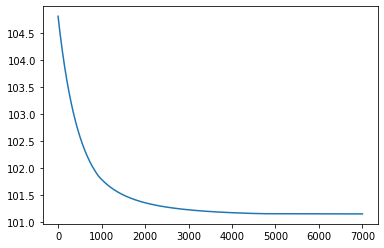

In [316]:
plt.plot(J1)

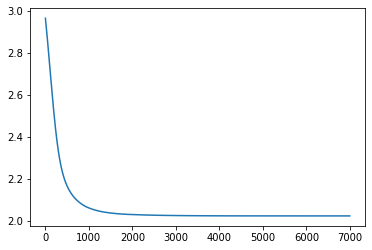

In [317]:
plt.plot(J2)

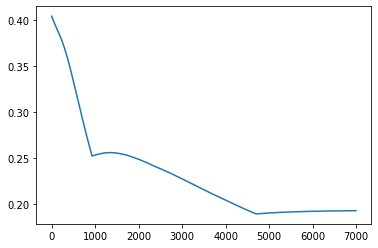

In [318]:
plt.plot(J3)

In [319]:
X_lr, X_tr = f_learned(opt_para_sgd[0],opt_para_sgd[1],dic,X0,t,dt)


/Users/rkyoon/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
/Users/rkyoon/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


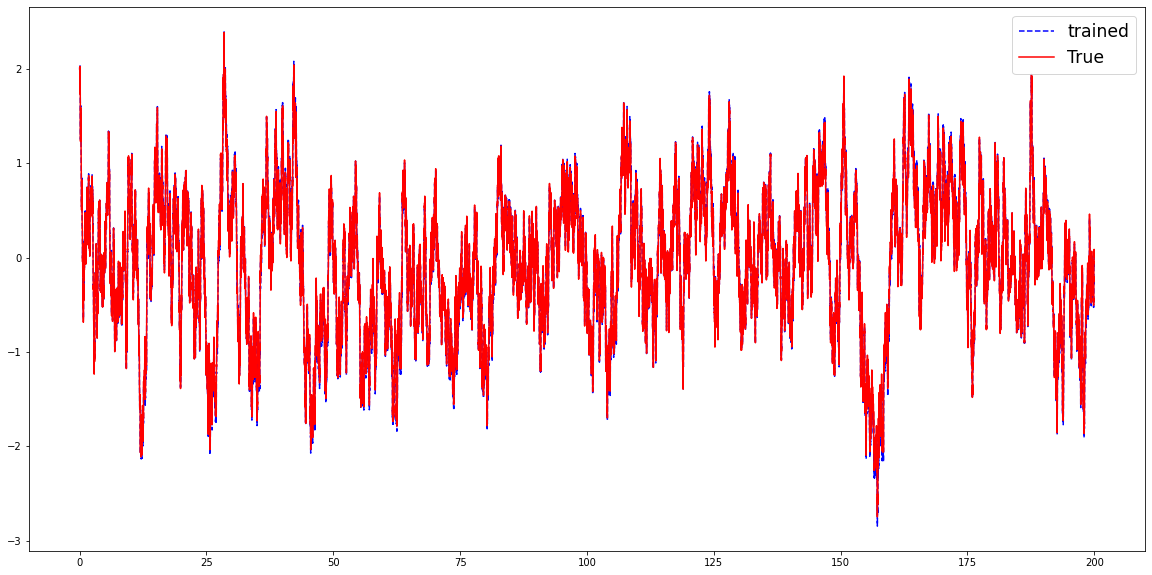

In [320]:

plt.figure(figsize=(20, 10))
plt.plot(t,X_lr,'b--',label='trained')
plt.plot(t,X_tr ,'r',label='True')

plt.legend(fontsize = 'xx-large')
plt.show()

In [321]:
def dic(Xt):
    return np.column_stack((np.ones((len(Xt),)),Xt,Xt**2/2, np.sin(Xt),np.cos(Xt)))

In [322]:
lr = 0.001
N_epoch = 7000
lamb = 0.1
N, dn = dic(Xt).shape
grad_loss = grad(loss)
para_ini = (np.random.normal(0,1,(dn,)), ( np.random.normal(0,1,(dn,))))
print('initial', para_ini)

para_ini = np.array([np.random.normal(0,1,(dn,)), np.abs( np.random.normal(0,1,(dn,)))])
grad_loss = grad(loss)

opt_para_sgd = sgd(grad_loss, para_ini, step_size=lr, num_iters=N_epoch)
print('sgd', opt_para_sgd[0],opt_para_sgd[1] )

opt_para_adam = adam(grad_loss, para_ini, step_size=lr, num_iters=N_epoch)
print('adam', opt_para_adam[0], opt_para_adam[1])

Mu, Sig, Loss,J1,J2,J3 = training(loss, grad_loss, para_ini,N_epoch, lr,lamb)   
opt_mu = Mu[-1]
opt_sig = Sig[-1]
print('own', opt_mu, opt_sig)


initial (array([-0.37708291,  1.83389358,  1.23774048,  0.49915009,  0.09122915]), array([-0.52319696,  0.40177537,  0.19157825, -0.21649522,  0.63761414]))
sgd [ 8.87956125e-06 -7.87608972e-01 -2.79112209e-02 -2.00369451e-01
  2.58303066e-05] [ 7.97871373e-01 -1.82621500e-06  1.29548227e-01 -1.10542737e-05
  2.02739870e-01]
adam [ 6.25764198e-05 -9.36292514e-01 -1.02826718e-03 -2.44878428e-03
 -1.91636960e-05] [ 0.73057453  0.07967483  0.19706527 -0.11459935  0.2666109 ]
own [-5.31842922e-05 -7.88294307e-01 -2.83272848e-02 -1.99553550e-01
 -6.05287371e-05] [ 8.16149039e-01 -1.48249511e-04  1.15270932e-01 -3.96976652e-05
  1.83966723e-01]


In [323]:
print('sgd')
print(opt_para_sgd[0],opt_para_sgd[1])
print(loss_print(opt_para_sgd))
print(np.sum(loss_print(opt_para_sgd)))

sgd
[ 8.87956125e-06 -7.87608972e-01 -2.79112209e-02 -2.00369451e-01
  2.58303066e-05] [ 7.97871373e-01 -1.82621500e-06  1.29548227e-01 -1.10542737e-05
  2.02739870e-01]
(101.1380557142662, 2.0254298090089926, 0.21460967028190933)
103.3780951935571


In [326]:
mu_true = np.array([0,-1,0,0,0])
sig_true = np.array([1,0,0,0,0])
print(mu_true,sig_true)
print(loss_print([mu_true,sig_true]))
print(np.sum(loss_print([mu_true,sig_true])))

[ 0 -1  0  0  0] [1 0 0 0 0]
(101.13942541964093, 2.023756217577032, 0.2)
103.36318163721796


In [327]:
X_lr, X_tr = f_learned(opt_para_sgd[0],opt_para_sgd[1],dic,X0,t,dt)


/Users/rkyoon/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
/Users/rkyoon/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


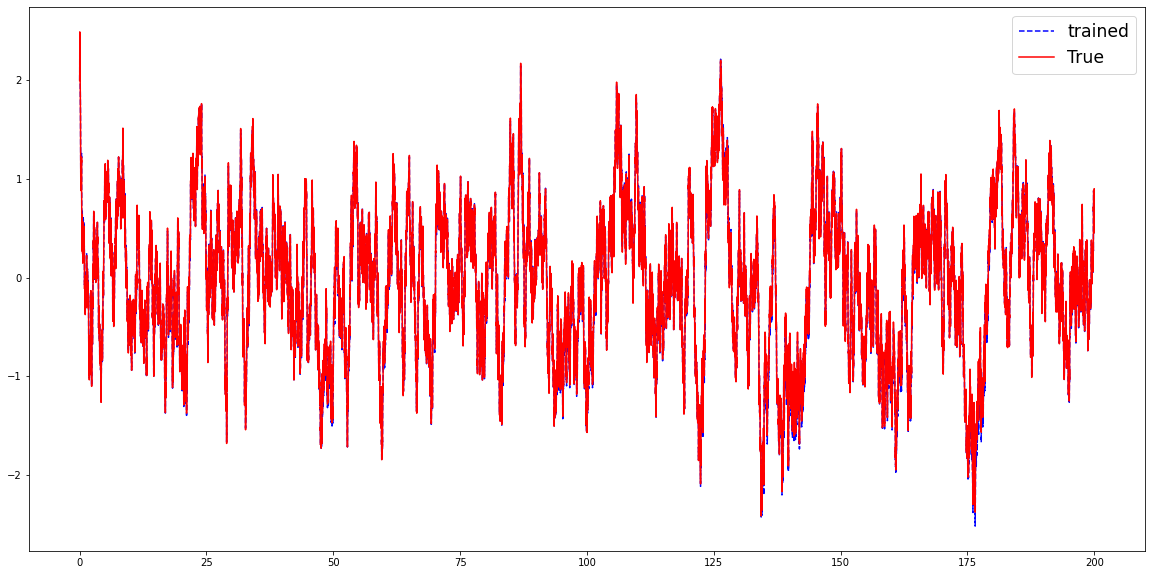

In [328]:

plt.figure(figsize=(20, 10))
plt.plot(t,X_lr,'b--',label='trained')
plt.plot(t,X_tr ,'r',label='True')

plt.legend(fontsize = 'xx-large')
plt.show()